# De la regresión lineal frecuentista a la regresión lineal bayesiana

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

import pymc as pm
import arviz as az

import matplotlib.pyplot as plt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Regresión bayesiana

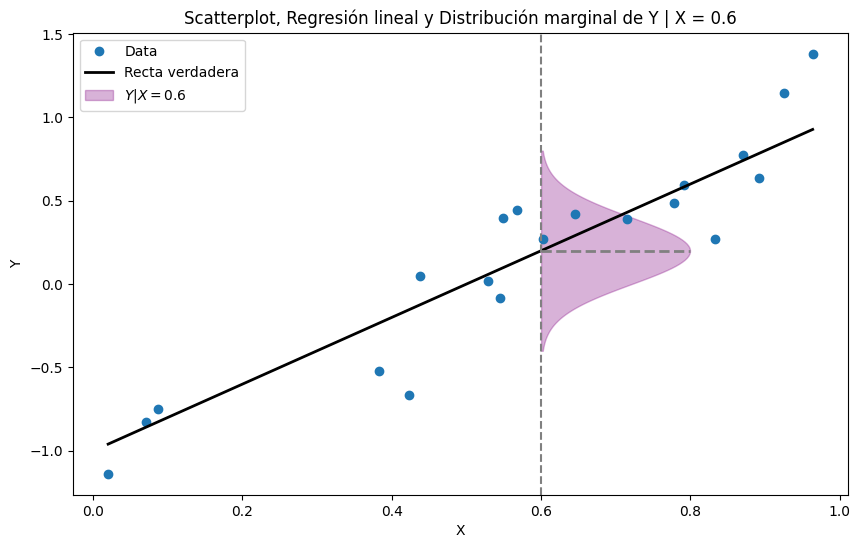

In [2]:
# Parámetros
np.random.seed(0)
n = 20
true_betas = [-1, 2]
std_dev = 0.2

# Generación de datos
x = stats.uniform.rvs(size=n)
y = true_betas[0]  + true_betas[1] * x + np.random.normal(0, std_dev, n)


# Construir eje x y rectas de regresión (verdadera y estimada)
x_axis = np.linspace(x.min(), x.max(), 1000)
ground_truth = true_betas[0]+ true_betas[1]*x_axis


# Armar el plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, 'o', label='Data')
ax.plot(x_axis,ground_truth,'k-', linewidth=2, label='Recta verdadera')


# Línea vertical en x = 0.6
x_value = 0.6
ax.axvline(x=x_value, color='grey', linestyle='--')

# Distribución marginal de y|x
mean_y_given_x = true_betas[0] + true_betas[1] * x_value
y_vals = np.linspace(mean_y_given_x - 3*std_dev, mean_y_given_x + 3*std_dev, 100)
pdf_vals = stats.norm.pdf(y_vals, mean_y_given_x, std_dev)

# Graficar la distribución en la posición de x=0.6
ax.fill_betweenx(y_vals, x_value, x_value + pdf_vals * 0.1, color='purple', alpha=0.3, label=r'$Y | X = 0.6$')
ax.plot([x_value, x_value + stats.norm.pdf(mean_y_given_x, mean_y_given_x, std_dev) * 0.1], [mean_y_given_x, mean_y_given_x], color='grey', linestyle='--', linewidth=2)

# Etiquetas y leyenda
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatterplot, Regresión lineal y Distribución marginal de Y | X = 0.6")
plt.legend()
plt.show()

In [3]:
# y = beta_0 + beta_1 * x + epsilon
# epsilon \sim N(0, sigma^2)

In [4]:
# Estimamos

# El modelo frecuentista
def linear_regression(x, y):
    X = np.stack([np.ones(len(x)), x], axis=0).T
    return np.linalg.inv(X.T @ X) @ X.T @ y

betas_hat = linear_regression(x, y)



# El modelo bayesiano
with pm.Model() as linear_model:
  # Priors
  beta0 = pm.Normal('beta0', mu=0, sigma=10)
  beta1 = pm.Normal('beta1', mu=0, sigma=10)
  sigma = pm.HalfNormal('sigma', sigma=1)

  # likelihood
  mu = beta0 + beta1*x
  y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

  # Samplear de la posterior
  idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


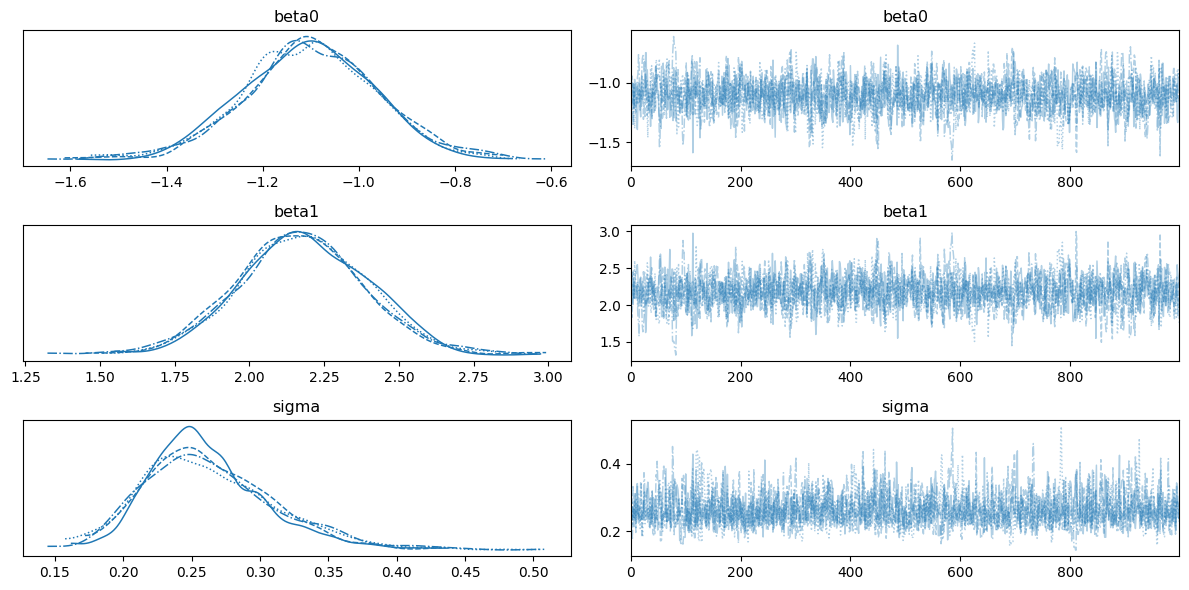

In [5]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

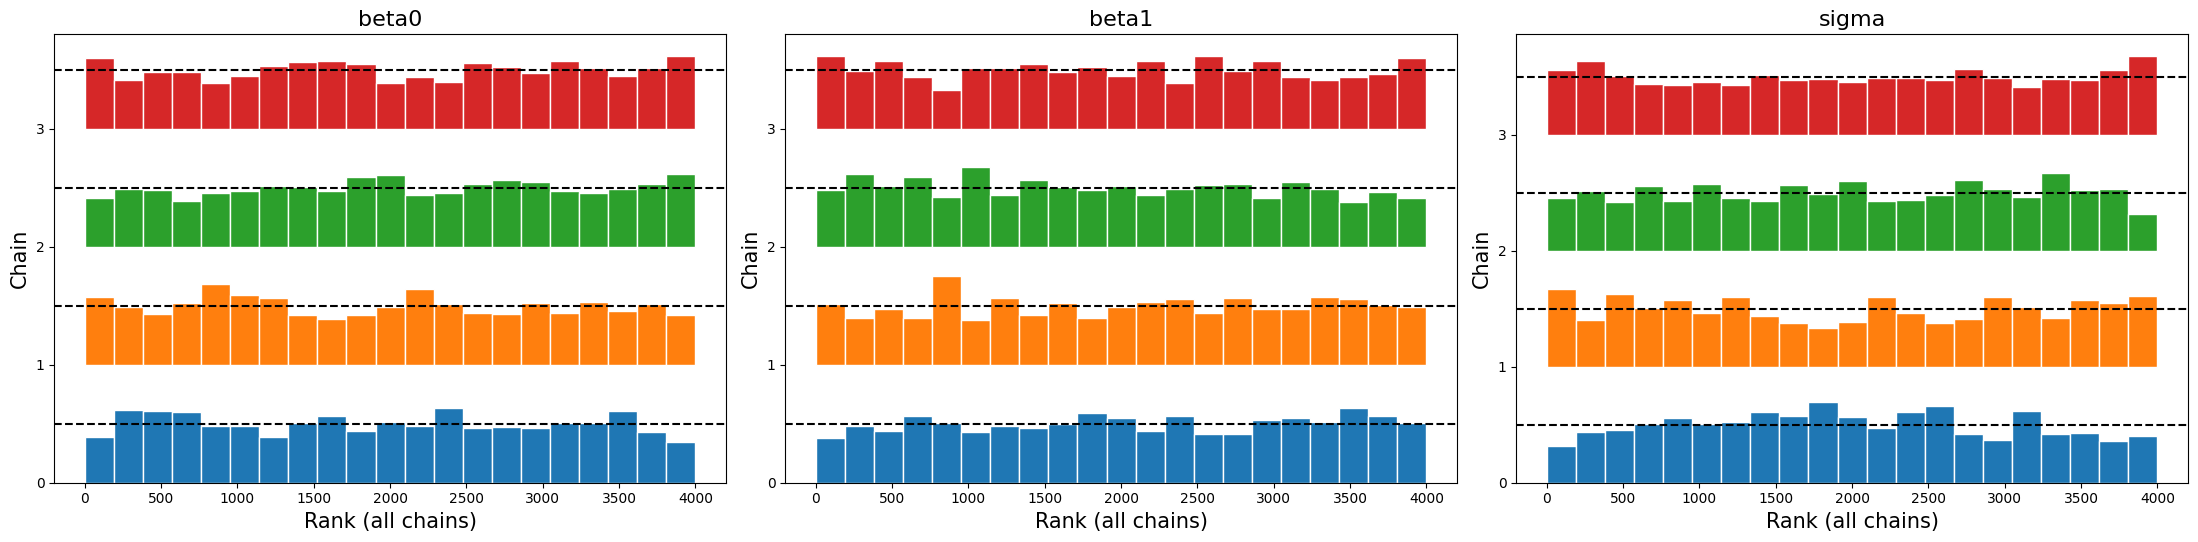

In [6]:
az.plot_rank(idata)
plt.tight_layout()
plt.show()

In [7]:
# Extraer samples de la posterior
samples = idata.posterior[['beta0', 'beta1']].stack(samples=("chain", "draw"))


In [10]:
az.summary(idata) #, hdi=0.95

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-1.101,0.140,-1.375,-0.852,0.004,0.003,1336.0,1551.0,1.00
beta1,2.177,0.215,1.773,2.568,0.006,0.004,1308.0,1621.0,1.00
sigma,0.263,0.048,0.182,0.354,0.001,0.001,1475.0,1209.0,1.01


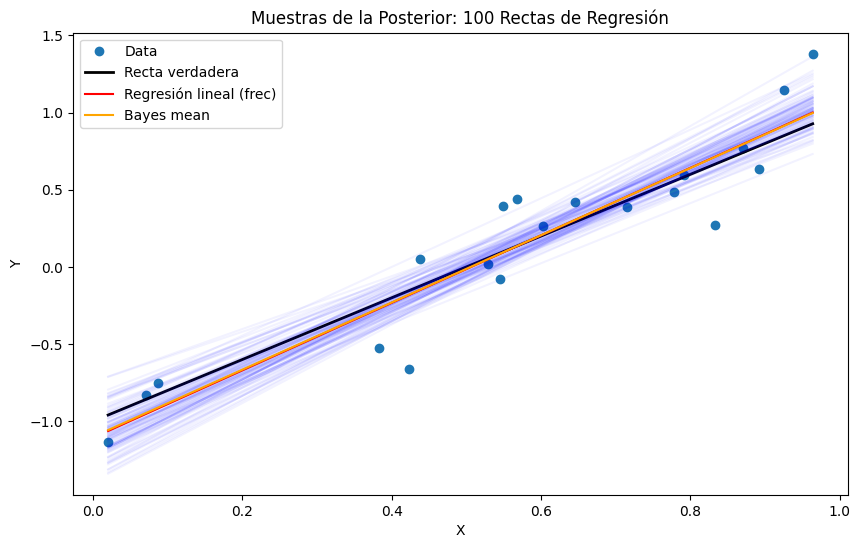

In [11]:

# Armar el plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, 'o', label='Data')
ax.plot(x_axis,ground_truth,'k-', linewidth=2, label='Recta verdadera')


# Graficar 100 rectas de regresión a partir de la posterior
for i in range(100):
    beta0_sample = samples['beta0'][i].values
    beta1_sample = samples['beta1'][i].values
    y_sample = beta0_sample + beta1_sample * x_axis
    ax.plot(x_axis, y_sample, color='blue', alpha=0.05)
# Agregar estimacion MCO
y_frec = betas_hat[0] + betas_hat[1] * x_axis
ax.plot(x_axis,y_frec,color='red',label='Regresión lineal (frec)')


beta0_sample = samples['beta0'].values.mean()
beta1_sample = samples['beta1'].values.mean()
y_sample = beta0_sample + beta1_sample * x_axis
ax.plot(x_axis, y_sample, color='orange', label='Bayes mean')



# Etiquetas y leyenda
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Muestras de la Posterior: 100 Rectas de Regresión")
plt.legend()
plt.show()

In [13]:
X = np.stack([np.ones(len(x)), x], axis=0).T
var_cov = np.linalg.inv(X.T @ X)

sigma2 = ((y-X@betas_hat)**2).sum()/(n-2)
sigma = np.sqrt(sigma2)

conf_int_beta_1 = betas_hat[1] - 2*sigma*np.sqrt(var_cov[1,1]), betas_hat[1] + 2*sigma*np.sqrt(var_cov[1,1])
conf_int_beta_1

(1.7910636382659337, 2.5829008665625164)

como los beta hat son variables aleatorias, los limites de mi intervalo de confianza son variables aletorias. Por ende, con datos nuevos tendria estimaciones distintas

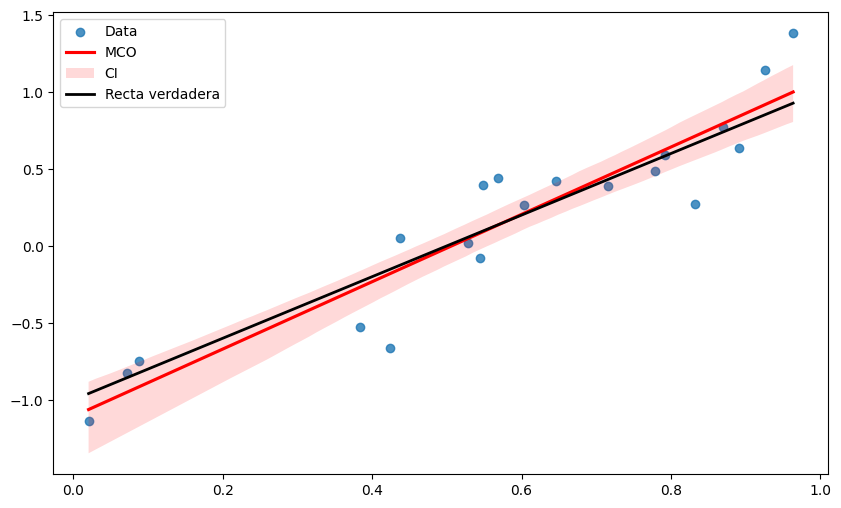

In [ ]:

# Intervalos de confianza para mu en paradigma frecuentista
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x=x, y=y,line_kws={'color': 'red'}, ax=ax)
ax.plot(x_axis,ground_truth,'k-', linewidth=2)
ax.legend(['Data','MCO', 'CI','Recta verdadera'])
plt.show()

# Ejercicio simil 1er parcial

Supongamos el siguiente modelo
$$
X_1 \sim \mathcal{U}(0,1)
$$
$$
X_2 \sim \mathcal{U}(0,1)
$$

$$
Z = X_1 + \mathcal{N}(0,1)
$$

$$
\mu = X_1 + X_2 + Z
$$

$$
y \sim \mathcal{N}(\mu, 1)
$$

del cual tenemos $n=100$ observaciones

y queremos:

1. Hacer la estimación bayesiana del MRLM (modelo regresion lineal multiple)
1. Las distribuciones posteriores (conjuntas y marginales)
1. Las estimaciones por intervalos (HDI 95%) para los coeficientes del modelo lineal
1. La estimacion por intervalos (HDI 90%) para $Y|(X_1=X_2=Z=1/2)$



## Primera parte: Probabilidad
Del modelo a los datos

In [14]:
# Generar datos
n = 20  # Número de observaciones
X1 = stats.uniform.rvs(0, 1, n)
X2 = stats.uniform.rvs(0, 1, n)
Z = X1 + stats.norm.rvs(0, 1/5, n)
mu = X1 + X2 + Z
y = stats.norm.rvs(mu, 1)

# Crear un DataFrame
data = pd.DataFrame({'X1': X1, 'X2': X2, 'Z':Z, 'y': y})

## Segunda Parte: de los datos al modelo

Normalmente, nuestro análisis empieza acá: Tenemos acceso a la data, pero no tenemos idea cuál es el proceso estocástico que lo generó. La $estadística$ nos permite, a partir de los datos, inferir los parámetros del modelo probabilístico que lo generó (no sin error, por supuesto). Y siempre condicional a que la especificación del modelo que hayamos adoptado sea correcta

In [61]:
# Especificar el modelo de regresión lineal (bayesiana)

with pm.Model() as multi_model:

    # Priors para los coeficientes
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    beta3 = pm.Normal('beta3', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=5)

    # Modelo lineal
    mu = beta0 + beta1 * data['X1'] + beta2 * data['X2'] + beta3 * data['Z']

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=data['y'])

    # Estimar el modelo (ie, samplear de la posterior)
    idata = pm.sample()

Output()

Output()

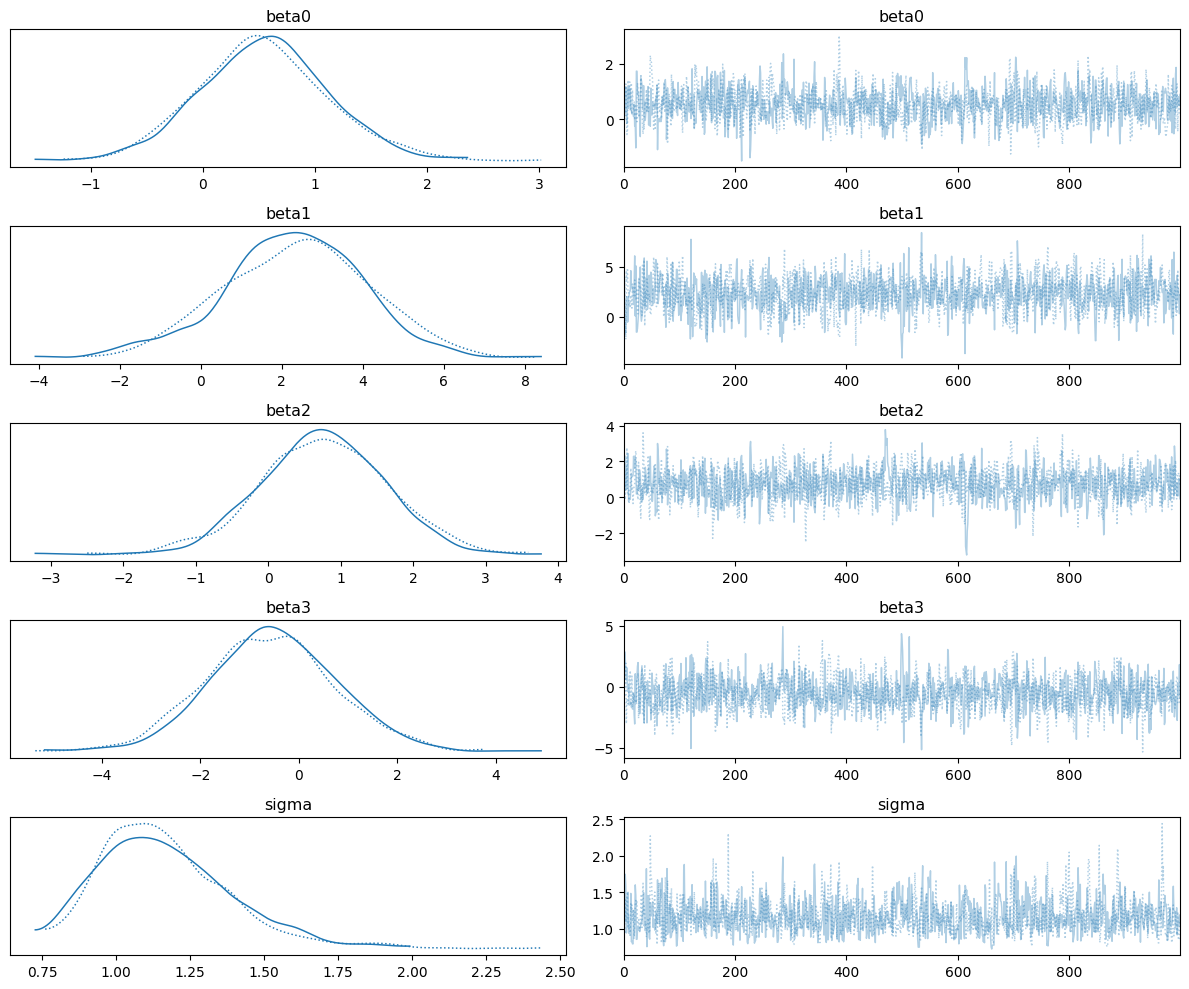

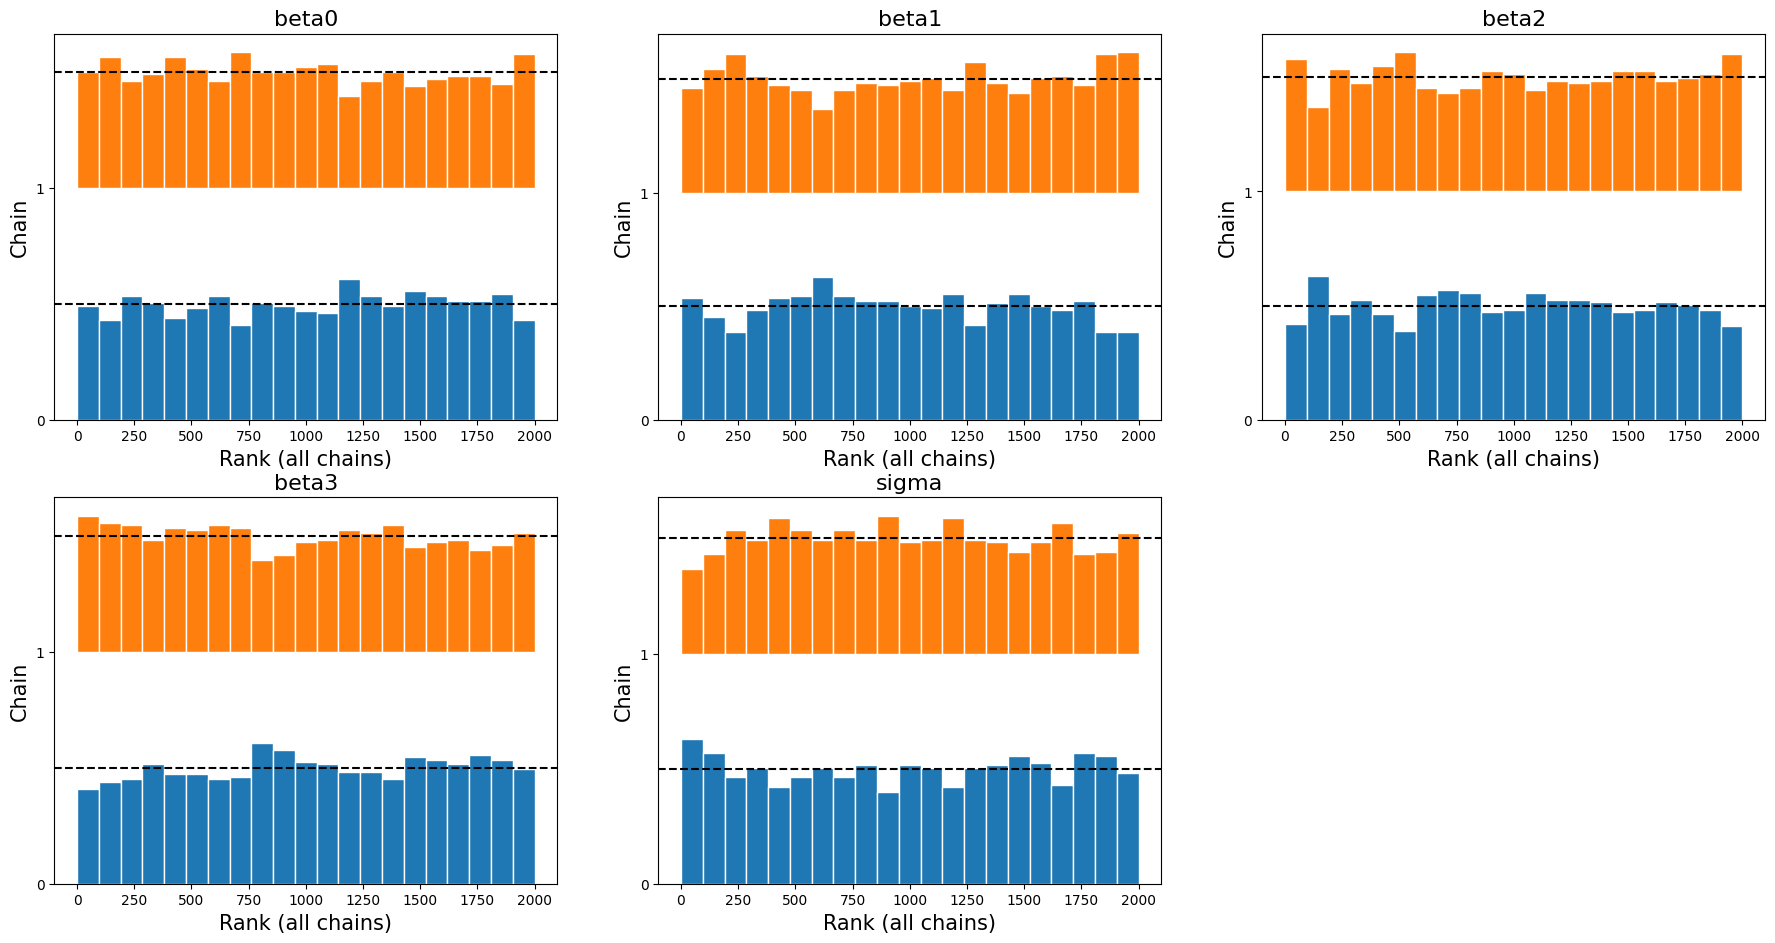

In [62]:
# Diagnóstico
az.plot_trace(idata)
plt.tight_layout()
plt.show()

az.plot_rank(idata)
plt.show()

Tercera parte: Producir estadísticos

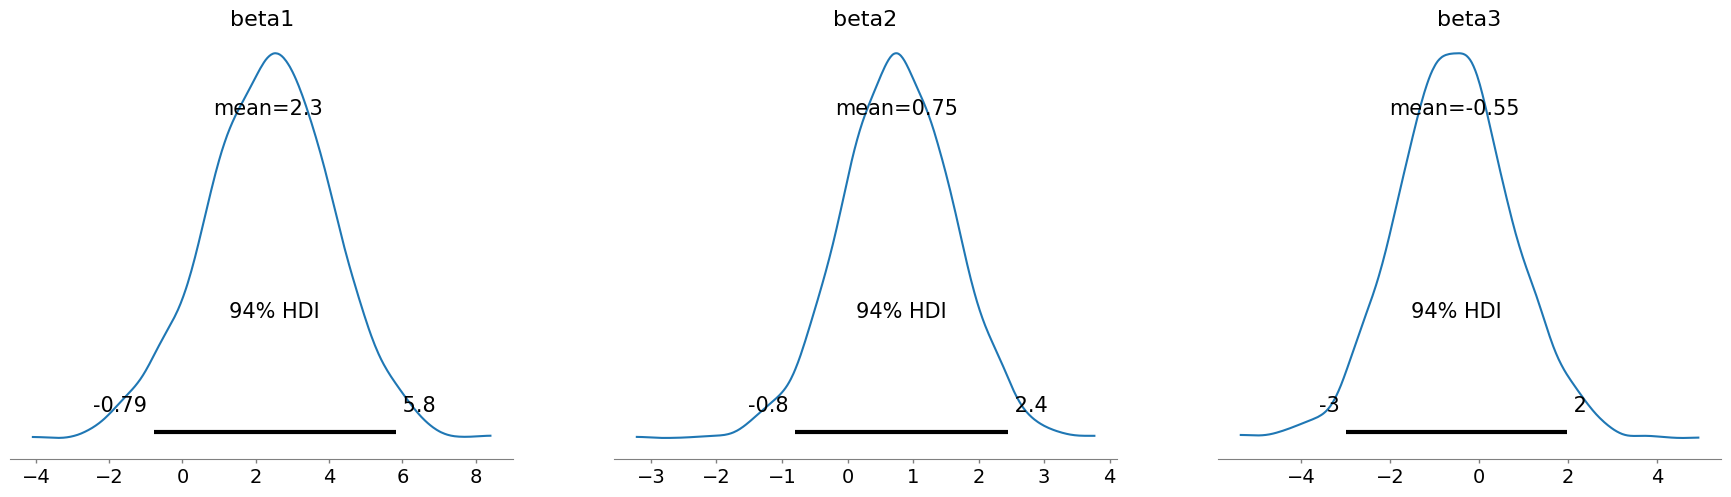

In [63]:
# Gráfico de las distribuciones marginales
az.plot_posterior(idata, var_names=['beta1', 'beta2', 'beta3'])
plt.show()

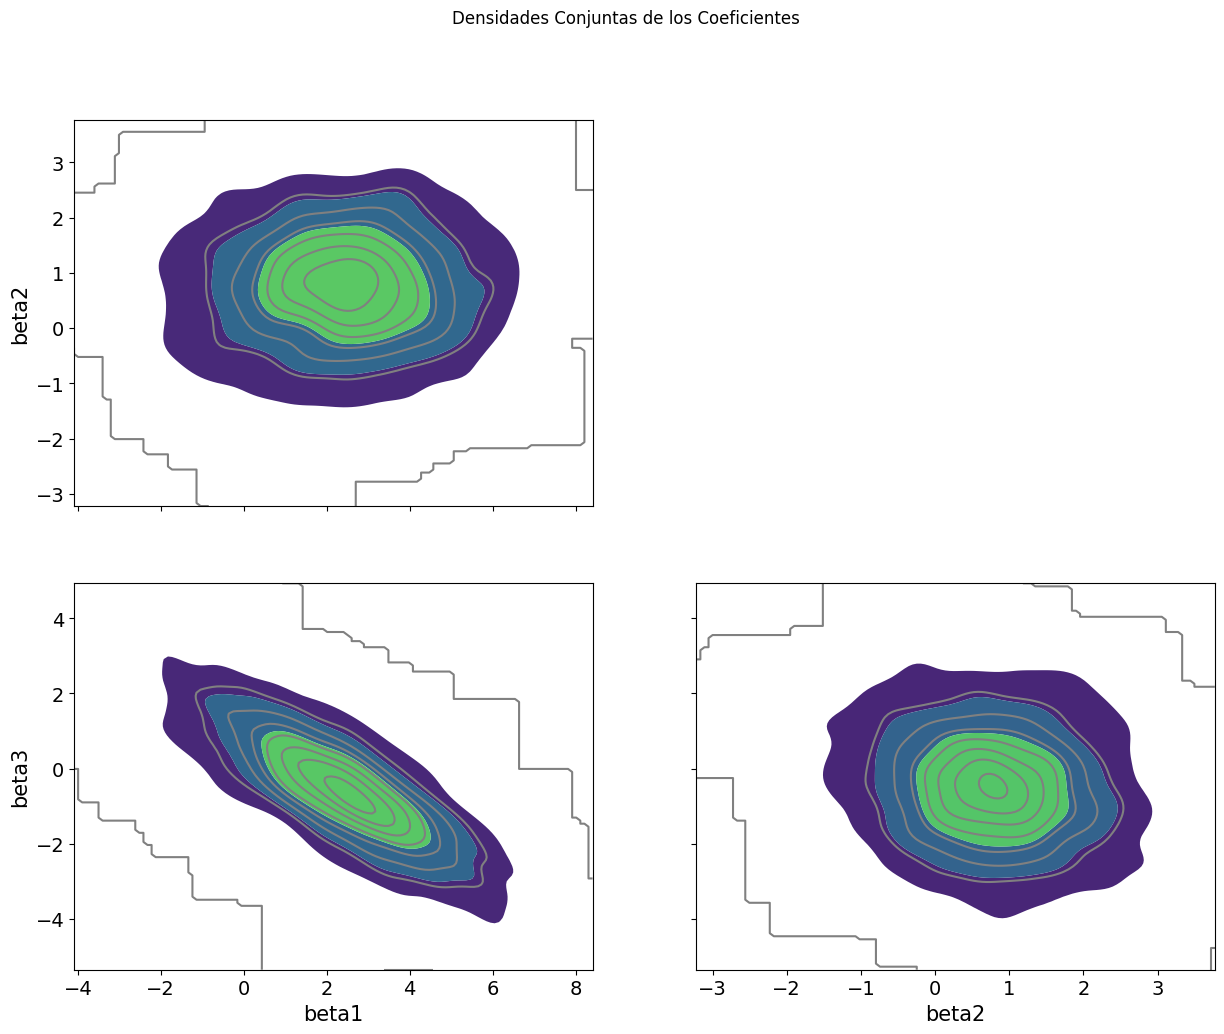

In [64]:
# Distribucion conjunta (en pares)
az.plot_pair(idata, var_names=["beta1", "beta2", "beta3"], kind="kde")
plt.suptitle("Densidades Conjuntas de los Coeficientes")
plt.show()

In [65]:
# Calcular los intervalos de credibilidad (HDI) para los coeficientes
hdi_coefs = az.hdi(idata, hdi_prob=0.95, var_names=['beta1', 'beta2', 'beta3'])

print("HDI 95% para beta1:", hdi_coefs['beta1'].values)
print("HDI 95% para beta2:", hdi_coefs['beta2'].values)
print("HDI 95% para beta2:", hdi_coefs['beta3'].values)

HDI 95% para beta1: [-1.03287891  5.82038267]
HDI 95% para beta2: [-0.97140124  2.44561672]
HDI 95% para beta2: [-3.03858734  2.08844093]


In [66]:
with multi_model:
    # Definir los valores de X1, X2, Z para la predicción
    X1_new = 0.5
    X2_new = 0.5
    Z_new = 0.5

    # Predecir Y para los nuevos X's
    mu_pred = pm.Deterministic('mu-pred', beta0 + beta1 * X1_new + beta2 * X2_new + beta3 * Z_new)
    y_pred = pm.Normal('y_pred', mu=mu_pred, sigma=sigma)

In [67]:
with multi_model:
      idata_pred = pm.sample(var_names = ['mu-pred','y_pred'])

Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [68]:
# Calcular el HDI 90% para las predicciones
hdi_pred = az.hdi(idata_pred, hdi_prob=0.90)
print("HDI 90% para Y|X=1/2:", hdi_pred['y_pred'].values)
print("HDI 90% para mu(X=1/2):", hdi_pred['mu_pred'].values)

HDI 90% para Y|X=1/2: [-0.10310572  3.78992012]


KeyError: "No variable named 'mu_pred'. Variables on the dataset include ['mu-pred', 'y_pred', 'hdi']"

In [ ]:
with multi_model:
  beta_sum = pm.Deterministic('beta_sum', beta1 + beta3)
  idata = pm.sample()

In [ ]:
# Gráfico de las distribuciones marginales
az.plot_posterior(idata, var_names=['beta1', 'beta3', 'beta_sum'])
plt.show()